# Randomforest

## Could I use decision tree for better result? What if we use multiple decision trees

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. (https://en.wikipedia.org/wiki/Random_forest)



In [1]:
"""randomforest_model.py: 

This model is the implementation of Classification of KDD datasets.
"""

__author__ = 'Youngseok Joung'
__copyright__ = "Copyright 2007, The Cogent Project"
__credits__ = ["Youngseok Joung"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Youngseok Joung"
__email__ = "none"
__status__ = "Production"

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as splitter
from sklearn.ensemble import RandomForestClassifier
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
import pickle
from joblib import dump, load

In [2]:
def labelEncoding(model_name, data):
    for column in data.columns:
        # If the data type of the cell is 'object'(Categorical), it will be transformed as a numerical 
        if data[column].dtype == type(object):
            le_file_path = 'result/' + model_name + '/' + model_name + '_' + column + '_encoder.pkl'
            if os.path.exists(le_file_path):
                pkl_file = open(le_file_path, 'rb')
                le = pickle.load(pkl_file) 
                pkl_file.close()
                data[column] = le.transform(data[column])            
            else:
                le = LabelEncoder()
                data[column] = le.fit_transform(data[column])
                #exporting the departure encoder
                output = open(le_file_path, 'wb')
                pickle.dump(le, output)
                output.close()
            if column == 'result':
                le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
                print(le_name_mapping)
                
    return data, le

In [3]:
def Preprocessing(model_name, data):
    y = data.result
    x = data.drop('result', axis=1)
    
    # Preprocessing: Split 7:3 Train: Test
    x_train, x_test, y_train, y_test = splitter(x, y, test_size=0.3)
    
    return x_train, x_test, y_train, y_test

In [4]:
def train_and_test(model_name, x_train, x_test, y_train, y_test):
    # Profile: Start 
    profile = cProfile.Profile()
    profile.enable()
    
    # train and test
    model = RandomForestClassifier()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Profile: End 
    profile.disable()
    profile.dump_stats('output.prof')
    stream = open('result/' + model_name + '/' + model_name + '_profiling.txt', 'w')
    stats = pstats.Stats('output.prof', stream=stream)
    stats.sort_stats('cumtime')
    stats.print_stats()
    os.remove('output.prof')
    
    # Freezing model for production 
    dump(model, 'result/' + model_name + '/' + model_name + '_model.joblib') 
    
    return model, y_pred

In [5]:
def report(model_name, y_test, y_pred, le=None):
    # Estimation: Confusion Matrix & classification-report 
    _confusion_matrix = confusion_matrix(y_test, y_pred)
    _classification_report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=False)
    _classification_report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

    # For Multiclass AUC
    _auc_dict = roc_auc_score_multiclass(y_test, y_pred)
    _auc_dict = dict((le.classes_[key], value) for (key, value) in _auc_dict.items())
#     _auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
#     _fpr, _tpr, _thresholds = roc_curve(y_test, y_pred)

    with open('result/' + model_name + '/' + model_name + '_output.txt', 'w') as f:
        f.write("\n---Confusion Matrix---\n")
        f.write(np.array2string(_confusion_matrix, separator=', '))
        f.write("\n---Classification Report---\n")
        f.write(_classification_report)
        f.write("\n---ROC AUC Score---\n")
        f.write(str(_auc_dict))
#         f.write(_auc)
    
    print('\n-----Confusion Matrix-----\n')
    print(_confusion_matrix)
    print('\n-----Classification Report-----\n')
    print(_classification_report)
    print('\n-----AUC Dictionary-----\n')
    print(str(_auc_dict))
    
    metrix = ['precision', 'recall', 'f1-score', 'support']
    xKeys = le.classes_
    for met in metrix:
        xValues = []
        for target_name in le.classes_:
            xValues += [_classification_report_dict[target_name][met]]

        pyplot.title(met)
        pyplot.bar(range(len(xValues)), list(xValues), align='center')
        pyplot.xticks(range(len(xKeys)), list(xKeys))
        pyplot.show()

    pyplot.title(met)
    pyplot.bar(range(len(xValues)), list(xValues), align='center')
    pyplot.xticks(range(len(xKeys)), list(xKeys))
    pyplot.show()
    
    pyplot.title('AUC')
    pyplot.bar(range(len(_auc_dict)), list(_auc_dict.values()), align='center')
    pyplot.xticks(range(len(_auc_dict)), list(_auc_dict.keys()))
    pyplot.show()
    
#     # plot the roc curve for the model
#     # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
#     pyplot.plot(_fpr, _tpr, marker='.', label=model_name)
#     # axis labels
#     pyplot.xlabel('False Positive Rate')
#     pyplot.ylabel('True Positive Rate')
#     # show the legend
#     pyplot.legend()
#     # show the plot
#     pyplot.show()
    
    return _confusion_matrix, _classification_report, _auc_dict, _classification_report_dict
    

In [6]:
def roc_auc_score_multiclass(y_test, y_pred, average = "macro"):
    #creating a set of all the unique classes using the actual class list
    unique_class = set(y_test)
    roc_auc_dict = {}
    for per_class in unique_class:
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_y_test = [0 if x in other_class else 1 for x in y_test]
        new_y_pred = [0 if x in other_class else 1 for x in y_pred]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_y_test, new_y_pred, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [7]:
model_name = 'randomforest_kdd'
# model_name = 'randomforest_nsl_kdd'
dataset_name = 'kdd_prediction'
# dataset_name = 'kdd_prediction_NSL'

data = pd.read_csv('./dataset/' + dataset_name + '.csv', delimiter=',', dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})
print(data.head)

<bound method NDFrame.head of        duration protocol_type   service  flag  src_bytes  dst_bytes      land  \
0     -0.106216           tcp      smtp    SF  -0.003736  -0.040352 -0.011722   
1     -0.107850           tcp      http    SF  -0.004276  -0.036652 -0.011722   
2     -0.107850           tcp      http    SF  -0.004262   0.005956 -0.011722   
3     -0.107033           tcp       ftp    SF  -0.003699  -0.006723 -0.011722   
4     -0.107850           udp  domain_u    SF  -0.004368  -0.044940 -0.011722   
...         ...           ...       ...   ...        ...        ...       ...   
13446 -0.107850           tcp      http    SF  -0.004225   0.049683 -0.011722   
13447 -0.107850           tcp      nntp  RSTO  -0.004392  -0.047028 -0.011722   
13448 -0.107033           tcp      smtp    SF  -0.003734  -0.041519 -0.011722   
13449 -0.107850           tcp      nnsp   REJ  -0.004392  -0.047028 -0.011722   
13450 -0.107850           tcp      link    S0  -0.004392  -0.047028 -0.011722  

In [8]:
# labeling
data, le = labelEncoding(model_name, data)

{'dos': 0, 'normal': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}


In [9]:
# Preprocessing
x_train, x_test, y_train, y_test = Preprocessing(model_name, data)


-----Confusion Matrix-----

[[1464    2   24    0    0]
 [   0 2266    1    0    0]
 [  31    3  121    0    0]
 [   0    6    2   97    2]
 [   0    2    1    0   14]]

-----Classification Report-----

              precision    recall  f1-score   support

         dos       0.98      0.98      0.98      1490
      normal       0.99      1.00      1.00      2267
       probe       0.81      0.78      0.80       155
         r2l       1.00      0.91      0.95       107
         u2r       0.88      0.82      0.85        17

    accuracy                           0.98      4036
   macro avg       0.93      0.90      0.91      4036
weighted avg       0.98      0.98      0.98      4036


-----AUC Dictionary-----

{'dos': 0.9851871866383379, 'normal': 0.9961050518873417, 'probe': 0.8867152629435381, 'r2l': 0.9532710280373832, 'u2r': 0.9115158877683942}


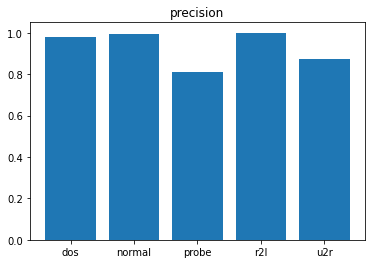

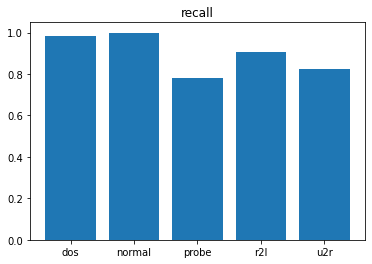

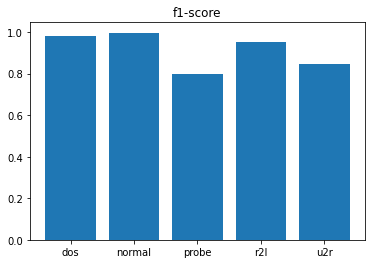

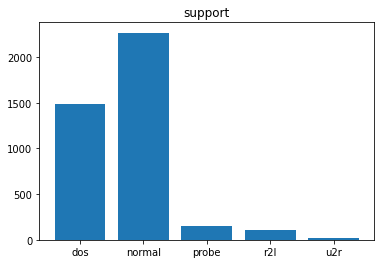

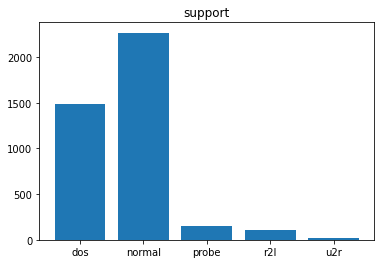

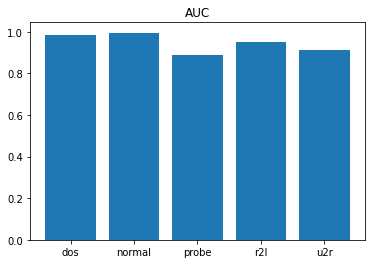

In [10]:
# Train and Test
model, y_pred = train_and_test(model_name, x_train, x_test, y_train, y_test)
# Report
cm, cr, auc, _ = report(model_name, y_test, y_pred, le)

In [11]:
def production(model_name, data):
    real_data, le = labelEncoding(model_name, data)
    real_y = real_data.result
    real_x = real_data.drop('result', axis=1)
#     print(real_y)
#     print(real_x)

    clf = load('result/' + model_name + '/' + model_name + '_model.joblib')
    yy_pred = clf.predict(real_x)
    pred_label = le.inverse_transform(yy_pred)
    real_label = le.inverse_transform(real_y)

    return pred_label, real_label

In [12]:
# Production
real_data = pd.read_csv('./dataset/kdd_prediction.csv', delimiter=',', dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})
real_data = real_data.head(1)

pred_label, real_label = production(model_name, real_data)
print(pred_label, real_label)

{'dos': 0, 'normal': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}
['normal'] ['normal']
